In [1]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-26 18:23:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.131.232, 54.231.229.8, 52.217.164.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.131.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  15.0MB/s    in 0.9s    

2023-11-26 18:23:28 (15.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Let us Inspect the data of the Jena weather dataset - 420451 rows and 15 Features**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

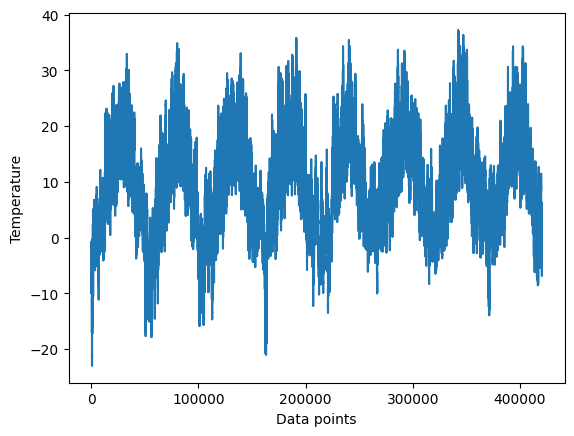

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

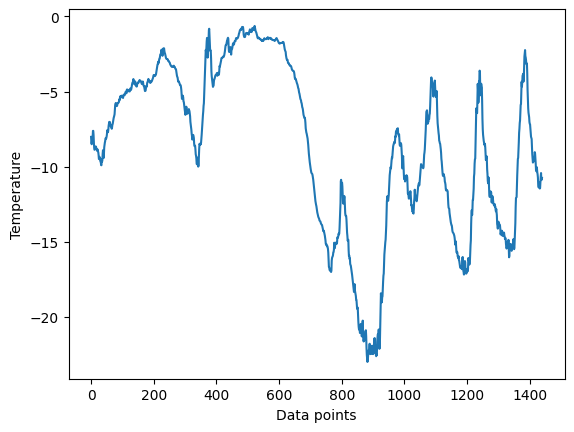

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Preparing the data**

Normalizing the data- because the data is already in a numerical format, vectorization is unnecessary. But given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Lets Inspect the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A common-sense, non-machine-learning baseline**

Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**A basic machine-learning model - Dense Layer**

Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [15]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 63s 76ms/step - loss: 11.9684 - mae: 2.6815 - val_loss: 10.1016 - val_mae: 2.5075
Epoch 2/10
819/819 [==============================] - 58s 70ms/step - loss: 8.8633 - mae: 2.3442 - val_loss: 10.2821 - val_mae: 2.5402
Epoch 3/10
819/819 [==============================] - 66s 80ms/step - loss: 8.2363 - mae: 2.2610 - val_loss: 10.6445 - val_mae: 2.5800
Epoch 4/10
819/819 [==============================] - 57s 70ms/step - loss: 7.8312 - mae: 2.2059 - val_loss: 10.9374 - val_mae: 2.6290
Epoch 5/10
819/819 [==============================] - 57s 70ms/step - loss: 7.5124 - mae: 2.1620 - val_loss: 10.4835 - val_mae: 2.5702
Epoch 6/10
819/819 [==============================] - 63s 77ms/step - loss: 7.2513 - mae: 2.1251 - val_loss: 11.4430 - val_mae: 2.6995
Epoch 7/10
819/819 [==============================] - 57s 69ms/step - loss: 7.0468 - mae: 2.0929 - val_loss: 12.5721 - val_mae: 2.8158
Epoch 8/10
819/819 [==============================] - 

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 24s 58ms/step - loss: 11.3023 - mae: 2.6513
Test MAE: 2.65


**Plotting results**

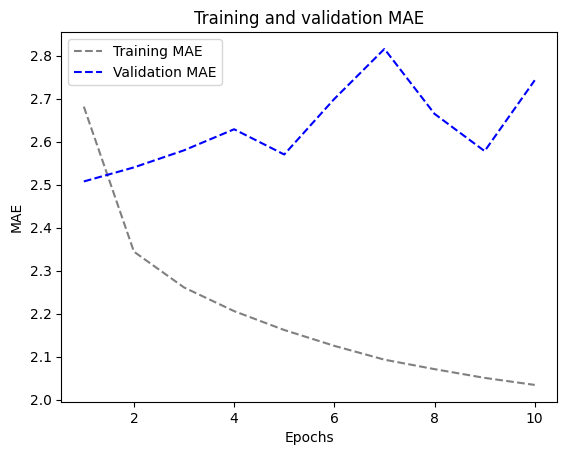

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Let's try a 1D convolutional model**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 104s 126ms/step - loss: 23.7642 - mae: 3.7943 - val_loss: 15.0512 - val_mae: 3.0404
Epoch 2/10
819/819 [==============================] - 129s 156ms/step - loss: 15.8971 - mae: 3.1592 - val_loss: 14.4778 - val_mae: 3.0138
Epoch 3/10
819/819 [==============================] - 124s 151ms/step - loss: 14.3293 - mae: 2.9987 - val_loss: 13.8583 - val_mae: 2.9162
Epoch 4/10
819/819 [==============================] - 125s 152ms/step - loss: 13.3559 - mae: 2.8923 - val_loss: 14.9046 - val_mae: 3.0131
Epoch 5/10
819/819 [==============================] - 104s 126ms/step - loss: 12.7314 - mae: 2.8237 - val_loss: 14.6268 - val_mae: 3.0125
Epoch 6/10
819/819 [==============================] - 120s 146ms/step - loss: 12.2874 - mae: 2.7730 - val_loss: 13.6981 - val_mae: 2.9033
Epoch 7/10
819/819 [==============================] - 103s 125ms/step - loss: 11.9085 - mae: 2.7252 - val_loss: 16.5126 - val_mae: 3.1846
Epoch 8/10
819/819 [==============

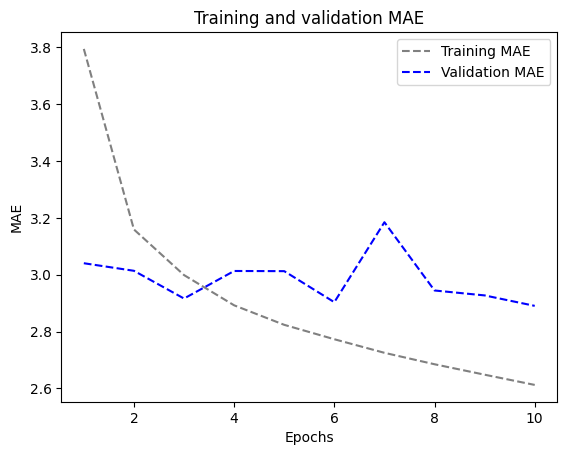

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems that the convolutional data performed poor compared to common sense or dense model. This could be because

- The assumption of translation invariance does not hold well for weather data.

- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.

**A Simple RNN**

**1.An RNN layer that can process sequences of any length**

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 102s 123ms/step - loss: 138.4136 - mae: 9.6796 - val_loss: 144.2225 - val_mae: 9.9228
Epoch 2/10
819/819 [==============================] - 104s 127ms/step - loss: 136.5719 - mae: 9.5779 - val_loss: 143.9311 - val_mae: 9.8960
Epoch 3/10
819/819 [==============================] - 82s 99ms/step - loss: 136.4449 - mae: 9.5691 - val_loss: 143.7999 - val_mae: 9.8798
Epoch 4/10
819/819 [==============================] - 104s 126ms/step - loss: 136.3508 - mae: 9.5601 - val_loss: 143.8433 - val_mae: 9.8895
Epoch 5/10
819/819 [==============================] - 83s 100ms/step - loss: 136.3097 - mae: 9.5559 - val_loss: 143.7985 - val_mae: 9.8815
Epoch 6/10
819/819 [==============================] - 102s 124ms/step - loss: 136.2641 - mae: 9.5512 - val_loss: 143.6823 - val_mae: 9.8669
Epoch 7/10
819/819 [==============================] - 83s 101ms/step - loss: 136.2426 - mae: 9.5496 - val_loss: 143.6784 - val_mae: 9.8704
Epoch 8/10
819/819 [====

**2.Simple RNN - Stacking RNN layers**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 167s 200ms/step - loss: 137.0325 - mae: 9.5811 - val_loss: 143.4336 - val_mae: 9.8385
Epoch 2/10
819/819 [==============================] - 162s 197ms/step - loss: 135.9434 - mae: 9.5119 - val_loss: 143.4635 - val_mae: 9.8441
Epoch 3/10
819/819 [==============================] - 164s 200ms/step - loss: 135.9016 - mae: 9.5056 - val_loss: 143.3922 - val_mae: 9.8322
Epoch 4/10
819/819 [==============================] - 174s 212ms/step - loss: 135.8781 - mae: 9.5025 - val_loss: 143.4095 - val_mae: 9.8357
Epoch 5/10
819/819 [==============================] - 176s 214ms/step - loss: 135.8522 - mae: 9.4991 - val_loss: 143.4118 - val_mae: 9.8354
Epoch 6/10
819/819 [==============================] - 155s 189ms/step - loss: 135.8375 - mae: 9.4964 - val_loss: 143.4204 - val_mae: 9.8355
Epoch 7/10
819/819 [==============================] - 167s 204ms/step - loss: 135.8279 - mae: 9.4952 - val_loss: 143.4286 - val_mae: 9.8362
Epoch 8/10
819/819 [

**A Simple GRU (Gated Recurrent Unit)**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 142s 170ms/step - loss: 40.1338 - mae: 4.6035 - val_loss: 12.5833 - val_mae: 2.6646
Epoch 2/10
819/819 [==============================] - 136s 166ms/step - loss: 10.5327 - mae: 2.5248 - val_loss: 9.3060 - val_mae: 2.3558
Epoch 3/10
819/819 [==============================] - 148s 181ms/step - loss: 9.4575 - mae: 2.4005 - val_loss: 9.1484 - val_mae: 2.3410
Epoch 4/10
819/819 [==============================] - 145s 177ms/step - loss: 9.0874 - mae: 2.3496 - val_loss: 9.0932 - val_mae: 2.3310
Epoch 5/10
819/819 [==============================] - 149s 181ms/step - loss: 8.8034 - mae: 2.3166 - val_loss: 9.0042 - val_mae: 2.3191
Epoch 6/10
819/819 [==============================] - 135s 165ms/step - loss: 8.5647 - mae: 2.2899 - val_loss: 8.9015 - val_mae: 2.3005
Epoch 7/10
819/819 [==============================] - 137s 166ms/step - loss: 8.3714 - mae: 2.2664 - val_loss: 9.4517 - val_mae: 2.3678
Epoch 8/10
819/819 [=========================

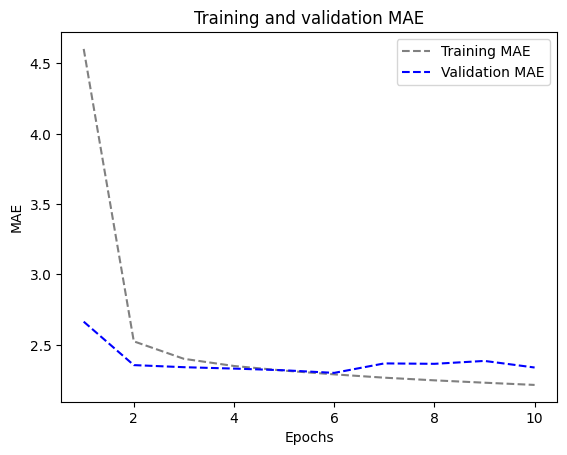

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**LSTM(Long Short-Term Memory )**


**1.LSTM-Simple**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 151s 181ms/step - loss: 38.2904 - mae: 4.4921 - val_loss: 11.8214 - val_mae: 2.6278
Epoch 2/10
819/819 [==============================] - 135s 165ms/step - loss: 10.9014 - mae: 2.5715 - val_loss: 9.8266 - val_mae: 2.4440
Epoch 3/10
819/819 [==============================] - 143s 174ms/step - loss: 9.9968 - mae: 2.4630 - val_loss: 9.6688 - val_mae: 2.4229
Epoch 4/10
819/819 [==============================] - 134s 164ms/step - loss: 9.6493 - mae: 2.4136 - val_loss: 9.7432 - val_mae: 2.4248
Epoch 5/10
819/819 [==============================] - 133s 162ms/step - loss: 9.4163 - mae: 2.3808 - val_loss: 9.5395 - val_mae: 2.4046
Epoch 6/10
819/819 [==============================] - 137s 167ms/step - loss: 9.1698 - mae: 2.3474 - val_loss: 9.5812 - val_mae: 2.4069
Epoch 7/10
819/819 [==============================] - 146s 178ms/step - loss: 8.9108 - mae: 2.3148 - val_loss: 9.3751 - val_mae: 2.3893
Epoch 8/10
819/819 [=========================

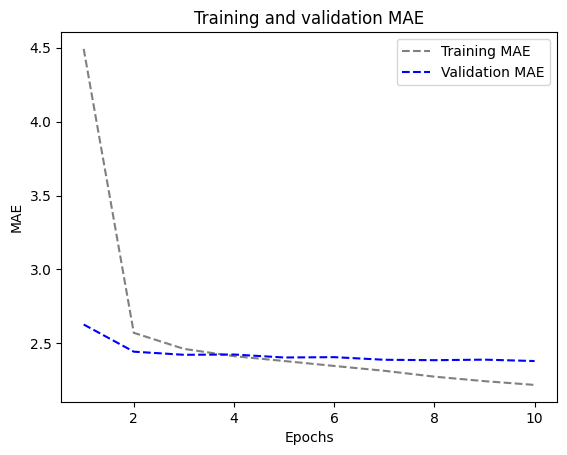

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 234s 281ms/step - loss: 43.4019 - mae: 4.9037 - val_loss: 12.8070 - val_mae: 2.7394
Epoch 2/10
819/819 [==============================] - 221s 269ms/step - loss: 19.9061 - mae: 3.4308 - val_loss: 10.0542 - val_mae: 2.4644
Epoch 3/10
819/819 [==============================] - 235s 287ms/step - loss: 18.2694 - mae: 3.2903 - val_loss: 9.7373 - val_mae: 2.4325
Epoch 4/10
819/819 [==============================] - 231s 281ms/step - loss: 17.4243 - mae: 3.2114 - val_loss: 9.5268 - val_mae: 2.4078
Epoch 5/10
819/819 [==============================] - 228s 278ms/step - loss: 16.8201 - mae: 3.1544 - val_loss: 9.5107 - val_mae: 2.3998
Epoch 6/10
819/819 [==============================] - 213s 260ms/step - loss: 16.3898 - mae: 3.1149 - val_loss: 9.4521 - val_mae: 2.3995
Epoch 7/10
819/819 [==============================] - 224s 273ms/step - loss: 16.0897 - mae: 3.0889 - val_loss: 9.4826 - val_mae: 2.3941
Epoch 8/10
819/819 [===================

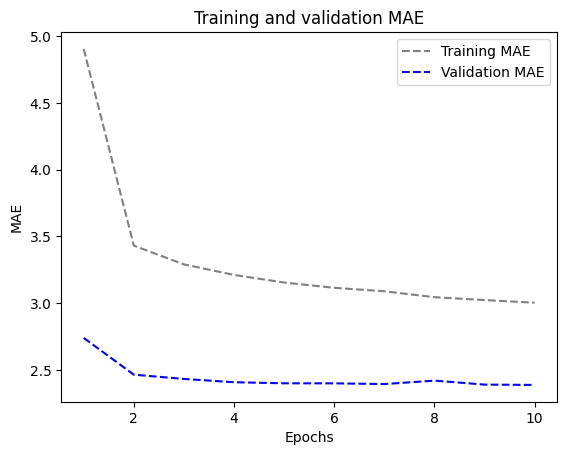

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 229s 275ms/step - loss: 35.4641 - mae: 4.3204 - val_loss: 12.3610 - val_mae: 2.6728
Epoch 2/10
819/819 [==============================] - 269s 327ms/step - loss: 9.8130 - mae: 2.4377 - val_loss: 10.1459 - val_mae: 2.4598
Epoch 3/10
819/819 [==============================] - 265s 323ms/step - loss: 8.4699 - mae: 2.2752 - val_loss: 10.1889 - val_mae: 2.4761
Epoch 4/10
819/819 [==============================] - 269s 328ms/step - loss: 7.8008 - mae: 2.1804 - val_loss: 10.9263 - val_mae: 2.5826
Epoch 5/10
819/819 [==============================] - 260s 318ms/step - loss: 7.2873 - mae: 2.1052 - val_loss: 10.2205 - val_mae: 2.4913
Epoch 6/10
819/819 [==============================] - 264s 322ms/step - loss: 6.8909 - mae: 2.0480 - val_loss: 10.6617 - val_mae: 2.5530
Epoch 7/10
819/819 [==============================] - 266s 325ms/step - loss: 6.5722 - mae: 1.9989 - val_loss: 10.9887 - val_mae: 2.6034
Epoch 8/10
819/819 [====================

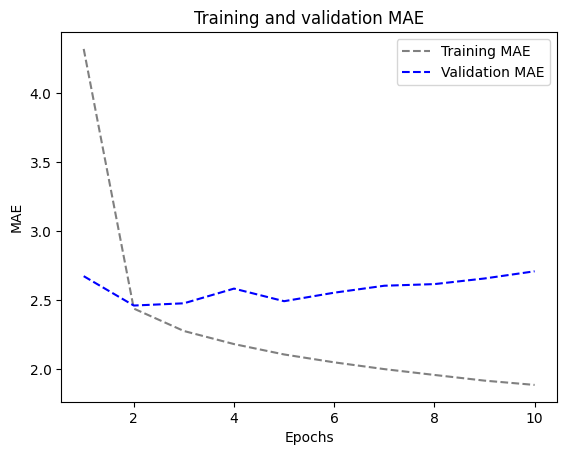

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 32 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 359s 429ms/step - loss: 17.9535 - mae: 3.0798 - val_loss: 9.7916 - val_mae: 2.4301
Epoch 2/10
819/819 [==============================] - 359s 438ms/step - loss: 7.9651 - mae: 2.1880 - val_loss: 10.6500 - val_mae: 2.5434
Epoch 3/10
819/819 [==============================] - 358s 437ms/step - loss: 6.4966 - mae: 1.9633 - val_loss: 11.3987 - val_mae: 2.6219
Epoch 4/10
819/819 [==============================] - 332s 405ms/step - loss: 5.6026 - mae: 1.8144 - val_loss: 11.9295 - val_mae: 2.6946
Epoch 5/10
819/819 [==============================] - 350s 427ms/step - loss: 4.9036 - mae: 1.6897 - val_loss: 11.6744 - val_mae: 2.6685
Epoch 6/10
819/819 [==============================] - 355s 433ms/step - loss: 4.3585 - mae: 1.5884 - val_loss: 12.5886 - val_mae: 2.7690
Epoch 7/10
819/819 [==============================] - 353s 431ms/step - loss: 3.9669 - mae: 1.5133 - val_loss: 12.0797 - val_mae: 2.7160
Epoch 8/10
819/819 [=====================

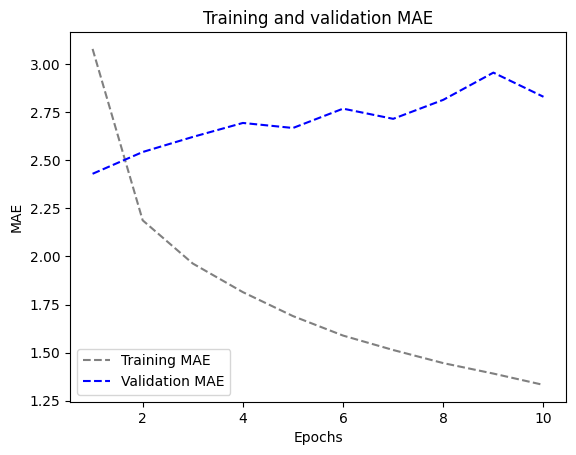

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 8 units**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 202s 241ms/step - loss: 65.5895 - mae: 6.1726 - val_loss: 32.5411 - val_mae: 4.2387
Epoch 2/10
819/819 [==============================] - 198s 241ms/step - loss: 20.1447 - mae: 3.3295 - val_loss: 12.3588 - val_mae: 2.6624
Epoch 3/10
819/819 [==============================] - 197s 240ms/step - loss: 11.0822 - mae: 2.5739 - val_loss: 9.9900 - val_mae: 2.4562
Epoch 4/10
819/819 [==============================] - 193s 235ms/step - loss: 9.8380 - mae: 2.4402 - val_loss: 9.8697 - val_mae: 2.4321
Epoch 5/10
819/819 [==============================] - 199s 243ms/step - loss: 9.4025 - mae: 2.3910 - val_loss: 9.6257 - val_mae: 2.4038
Epoch 6/10
819/819 [==============================] - 189s 230ms/step - loss: 9.1008 - mae: 2.3583 - val_loss: 10.3757 - val_mae: 2.4961
Epoch 7/10
819/819 [==============================] - 185s 226ms/step - loss: 8.8648 - mae: 2.3322 - val_loss: 9.7851 - val_mae: 2.4253
Epoch 8/10
819/819 [======================

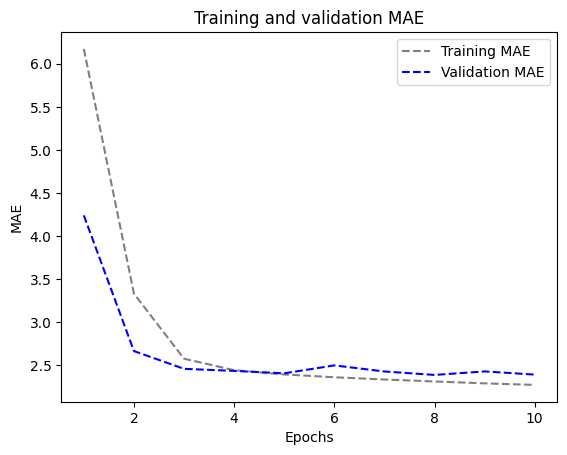

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**5.LSTM - dropout-regularized, stacked model**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 396s 472ms/step - loss: 64.6965 - mae: 6.1379 - val_loss: 28.2926 - val_mae: 3.9250
Epoch 2/10
819/819 [==============================] - 345s 422ms/step - loss: 29.6355 - mae: 4.0876 - val_loss: 12.9624 - val_mae: 2.7057
Epoch 3/10
819/819 [==============================] - 345s 421ms/step - loss: 24.1612 - mae: 3.7207 - val_loss: 10.9054 - val_mae: 2.5302
Epoch 4/10
819/819 [==============================] - 346s 422ms/step - loss: 22.5045 - mae: 3.6006 - val_loss: 10.2867 - val_mae: 2.4703
Epoch 5/10
819/819 [==============================] - 347s 423ms/step - loss: 21.1924 - mae: 3.5039 - val_loss: 10.0281 - val_mae: 2.4524
Epoch 6/10
819/819 [==============================] - 346s 422ms/step - loss: 20.1815 - mae: 3.4183 - val_loss: 10.0517 - val_mae: 2.4510
Epoch 7/10
819/819 [==============================] - 344s 419ms/step - loss: 19.4487 - mae: 3.3556 - val_loss: 10.0248 - val_mae: 2.4518
Epoch 8/10
819/819 [==============

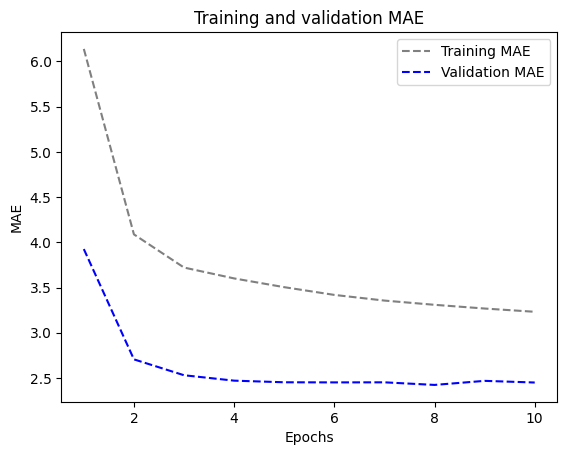

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**Bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 233s 277ms/step - loss: 26.0690 - mae: 3.6717 - val_loss: 10.5265 - val_mae: 2.5060
Epoch 2/10
819/819 [==============================] - 208s 254ms/step - loss: 9.7076 - mae: 2.4338 - val_loss: 10.2010 - val_mae: 2.4691
Epoch 3/10
819/819 [==============================] - 207s 252ms/step - loss: 8.8064 - mae: 2.3116 - val_loss: 9.6180 - val_mae: 2.4013
Epoch 4/10
819/819 [==============================] - 210s 257ms/step - loss: 8.2924 - mae: 2.2404 - val_loss: 10.2929 - val_mae: 2.4697
Epoch 5/10
819/819 [==============================] - 212s 258ms/step - loss: 7.8697 - mae: 2.1857 - val_loss: 9.8965 - val_mae: 2.4351
Epoch 6/10
819/819 [==============================] - 210s 256ms/step - loss: 7.5934 - mae: 2.1496 - val_loss: 10.4223 - val_mae: 2.4977
Epoch 7/10
819/819 [==============================] - 206s 252ms/step - loss: 7.3607 - mae: 2.1163 - val_loss: 10.5893 - val_mae: 2.5018
Epoch 8/10
819/819 [======================

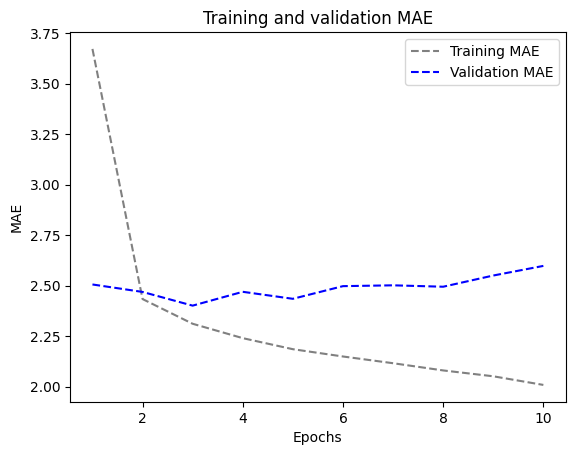

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 168s 200ms/step - loss: 48.2877 - mae: 5.2056 - val_loss: 25.5490 - val_mae: 3.9099
Epoch 2/10
819/819 [==============================] - 153s 186ms/step - loss: 17.7307 - mae: 3.2604 - val_loss: 21.7301 - val_mae: 3.7012
Epoch 3/10
819/819 [==============================] - 152s 184ms/step - loss: 14.5535 - mae: 2.9679 - val_loss: 22.9052 - val_mae: 3.8182
Epoch 4/10
819/819 [==============================] - 167s 204ms/step - loss: 12.8493 - mae: 2.7830 - val_loss: 24.1316 - val_mae: 3.8972
Epoch 5/10
819/819 [==============================] - 149s 182ms/step - loss: 11.6877 - mae: 2.6494 - val_loss: 23.1112 - val_mae: 3.8236
Epoch 6/10
819/819 [==============================] - 152s 185ms/step - loss: 10.8657 - mae: 2.5466 - val_loss: 23.4275 - val_mae: 3.8752
Epoch 7/10
819/819 [==============================] - 152s 185ms/step - loss: 10.1177 - mae: 2.4535 - val_loss: 23.1474 - val_mae: 3.8134
Epoch 8/10
819/819 [==============

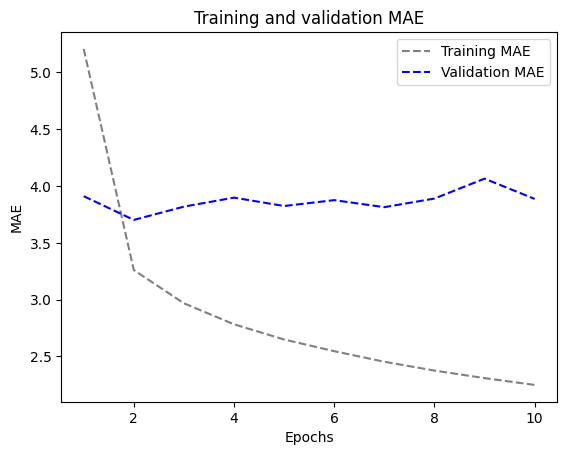

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**We have  built total  14 models**

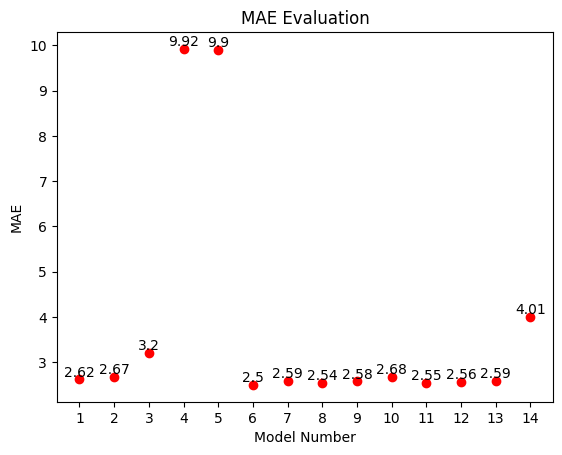

In [41]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()